In [189]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [190]:
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats

In [191]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


LOAD BRAIN DATA

In [193]:
epi_img = nib.load('gm_8.nii.gz')
epi_img_data = epi_img.get_fdata()
epi_img_data.shape

(79, 95, 79, 16)

PLOT 3 SLICES OF A SINGLE SAMPLE.

In [194]:
def show_slices(slices):
   fig, axes = plt.subplots(len(slices),1,figsize=(15, 15))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

PLOT REGIONS OF SIGNIFICANT DIFFERENCES. (DIM: VIEWS X THRESHOLD)

In [195]:
def show_diff(slices, rows, cols, mapc):
   fig, axes = plt.subplots(3,(int)(len(slices)/3),figsize=(15, 15))
   fig.suptitle('Plots across threshold')
   for ax, col in zip(axes[0], cols):
     ax.set_title(col, rotation=0)
   for ax, row in zip(axes[:,0], rows):
     ax.set_ylabel(row, rotation=90)

   fig.tight_layout()   
   for i in range((int)(len(slices)/3)):
     for j in range(3):
       axes[j,i].imshow(slices[3*i+j].T, cmap=mapc, origin="lower")

In [196]:
x = epi_img_data[:,:,:,0:8] #Healthy patients
y = epi_img_data[:,:,:,8:16] #Unhealthy patients

2 sample t-test makes an assumption that the 2 samples are independent and normally distributed. 2 samples are not related thus fulfilling the independence assumption. Inorder to test normality of the samples an attempt was made to use Shapiro-Wilk Test, however scipy.stats.shapiro does not work for N>5000. So an assumption for normaility is made: Given a sample $X$,
$X=\{x_1,x_2,...x_N\}$, a voxel $v_{i,j,k} \sim N(\mu_{i,j,k},\sigma_{i,j,k}^2)$ where $\mu_{i,j,k}=\sum_{a=1}^{N}x_a[i,j,k]$ and the computation for variance is similar as well.

In [197]:
# igonre division by NaN
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

Hypothesis testing<br>
Let $\mu_1$ and $\mu_2$ be the population voxel-wise means matrices for healthy patients $X = \{x_1,x_2,...,x_N\}$ and unhealthy patients $Y = \{y_1,y_2,...,y_N\}$ respectively.<br>
$\mu_1[i,j,k] = \sum_{a=1}^{N}x_a[i,j,k]$ <br>
$\mu_2[i,j,k] = \sum_{a=1}^{N}y_a[i,j,k]$
<br>
We perform 2-tailed test to highlight all the differences between healthy and unhealthy regions of the brain. Maybe brain degeneracies include extra growth as well decline of neurons etc.<br>
And we perform right tailed test to highlight all the regions present in the healthy brains which do not exist in degenerate brains. This case assumes brain degeneracies as only the decline in neurons in unhealthy brains.


1.   2-tailed test.

*   $H_0 : \mu_1 - \mu_2 = 0$
*   $H_1 : \mu_1 - \mu_2 \neq 0$


2.   Right tailed test.

*   $H_0 : \mu_1 - \mu_2 = 0$
*   $H_1 : \mu_1 - \mu_2 > 0$





Perform 2 sample t-test.<br>
Computing t-statistic.<br>
$t = \frac{(\overline{X}-\overline{Y})-(\mu_1 - \mu_2)}{(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2})^{0.5}}$ <br>
We want to compute probability of getting value $t$ or extreme given that the null hypothesis is true. Therefore we have the following:
$t = \frac{(\overline{X}-\overline{Y})}{(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2})^{0.5}}$ <br>

In [198]:
xb = np.mean(x, axis=3) #sample mean of each voxels across healthy patients
yb = np.mean(y, axis=3) #sample mean of each voxels across unhealthy patients
d = xb-yb #difference between sample means

#Sum of sqaured differences of healthy patient sample element and healthy patient sample mean.
sx = 0
for i in range(8):
  j = x[:,:,:,i]
  diff = (j-xb)**2
  sx += diff

#Sum of sqaured differences of unhealthy patient sample element and unhealthy patient sample mean.
sy = 0
for i in range(8):
  j = y[:,:,:,i]
  diff = (j-yb)**2
  sy += diff

#variance
sx=sx/7
sy=sy/7

den = ((sx+sy)/8)**0.5 #denominator of t-statistic
t=d/den #t-statistic

2 tailed test, alpha = 0.03 , with 0 and 1 valued voxel<br>
Compute p-value per voxel. <br>
Reject the null hypothesis i.e. accept the alternative hypothesis (difference exists between control and patient mean) if p-value is smaller than threshold. <br>
For voxels that reject the null hypothesis increase voxel intensity to 1 else 0.

In [208]:
#2 tailed test, alpha = 0.03 , with 0 and 1 valued voxel
p = scipy.stats.t.sf(abs(t), df=7)
p = p<=0.015
p = p.astype(int)

Plot brain slices of control-0 and patient-0.<br>
Plot significant regions of differences using 2 tailed test with varying thresholds and with 0 and 1 voxel intensity.

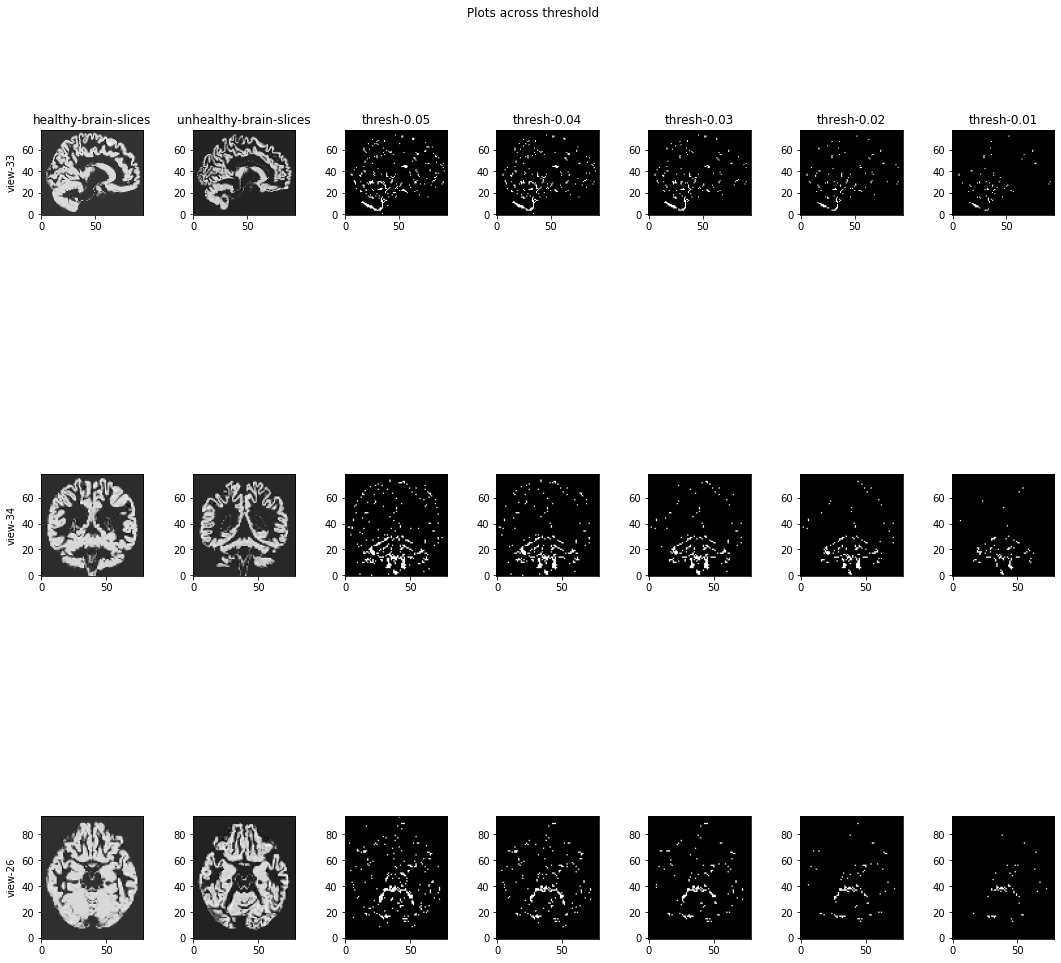

In [200]:
display_deg = []
display_deg.append(x[33,:,:,0])
display_deg.append(x[:,34,:,0])
display_deg.append(x[:,:,26,0])

display_deg.append(y[33,:,:,0])
display_deg.append(y[:,34,:,0])
display_deg.append(y[:,:,26,0])

for thresh in [0.025, 0.02, 0.015, 0.01, 0.005]:
  p = scipy.stats.t.sf(abs(t), df=7)
  p = p<=thresh
  p = p.astype(int)
  display_deg.append(p[33,:,:])
  display_deg.append(p[:,34,:])
  display_deg.append(p[:,:,26])
row = ['view-33','view-34','view-26']
col = ['healthy-brain-slices','unhealthy-brain-slices','thresh-0.05', 'thresh-0.04', 'thresh-0.03', 'thresh-0.02', 'thresh-0.01']
show_diff(display_deg,row,col,'gray')

right tailed test, alpha = 0.015, with 0 and 1 valued voxel. <br>
Compute p-value per voxel. <br>
Reject the null hypothesis i.e. accept the alternative hypothesis (control mean is greater than patient mean) if p-value is smaller than threshold. <br>
For voxels that reject the null hypothesis increase voxel intensity to 1 else 0.

In [210]:
#right tailed test, alpha = 0.015, with 0 and 1 valued voxel
p = scipy.stats.t.sf(abs(t), df=7)
p = p<=0.015
ind = np.argwhere(t<0)
for e in ind:
  p[e[0],e[1],e[2]] = 0
p = p.astype(int)

Plot brain slices of control-0 and patient-0.<br>
Plot significant regions of differences using right tailed test with varying thresholds with 0/1 intensity voxels.

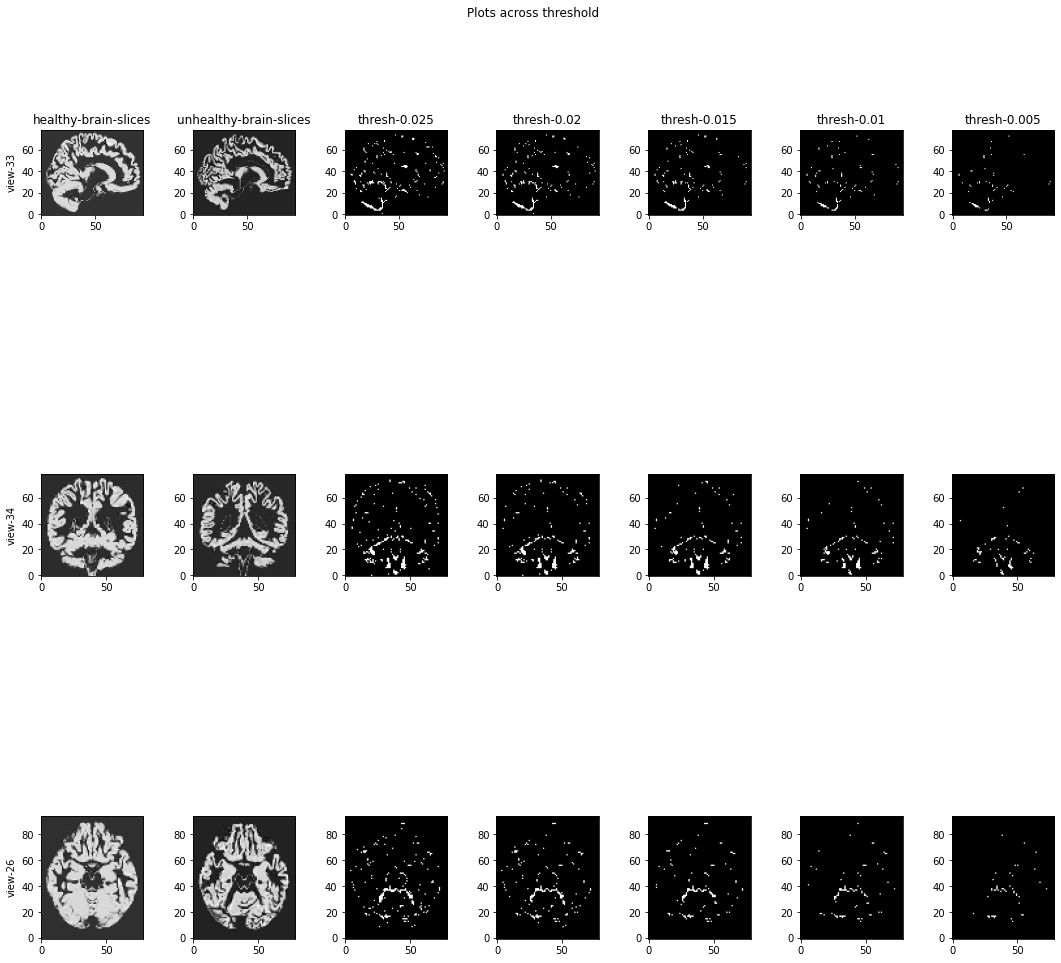

In [202]:
display_deg = []
display_deg.append(x[33,:,:,0])
display_deg.append(x[:,34,:,0])
display_deg.append(x[:,:,26,0])

display_deg.append(y[33,:,:,0])
display_deg.append(y[:,34,:,0])
display_deg.append(y[:,:,26,0])
for thresh in [0.025, 0.02, 0.015, 0.01, 0.005]:
  p = scipy.stats.t.sf(abs(t), df=7)
  p = p<=thresh
  ind = np.argwhere(t<0)
  for e in ind:
    p[e[0],e[1],e[2]] = 0
  p = p.astype(int)
  display_deg.append(p[33,:,:])
  display_deg.append(p[:,34,:])
  display_deg.append(p[:,:,26])
row = ['view-33','view-34','view-26']
col = ['healthy-brain-slices','unhealthy-brain-slices','thresh-0.025', 'thresh-0.02', 'thresh-0.015', 'thresh-0.01', 'thresh-0.005']
show_diff(display_deg,row,col,'gray')

right tailed test, alpha = 0.015, with 1-p-valued voxel intensity.<br>
Compute p-value per voxel. <br>
Reject the null hypothesis i.e. accept the alternative hypothesis (control mean is greater than patient mean) if p-value is smaller than threshold. <br>
For voxels that reject the null hypothesis voxel intensity = 1-p-value else 0.

In [212]:
#right tailed test, alpha = 0.015, with 1-p-valued voxel intensity
p = scipy.stats.t.sf(abs(t), df=7)
i = np.argwhere(p>0.015)
ind = np.argwhere(t<0)
for e in ind:
  p[e[0],e[1],e[2]] = 0
for ind in i:
  p[ind[0],ind[1],ind[2]] = 0
p = 1-p

Plot brain slices of control-0 and patient-0.<br>
Plot significant regions of differences using right tailed test with varying thresholds with 1-p-valued voxel intensity.

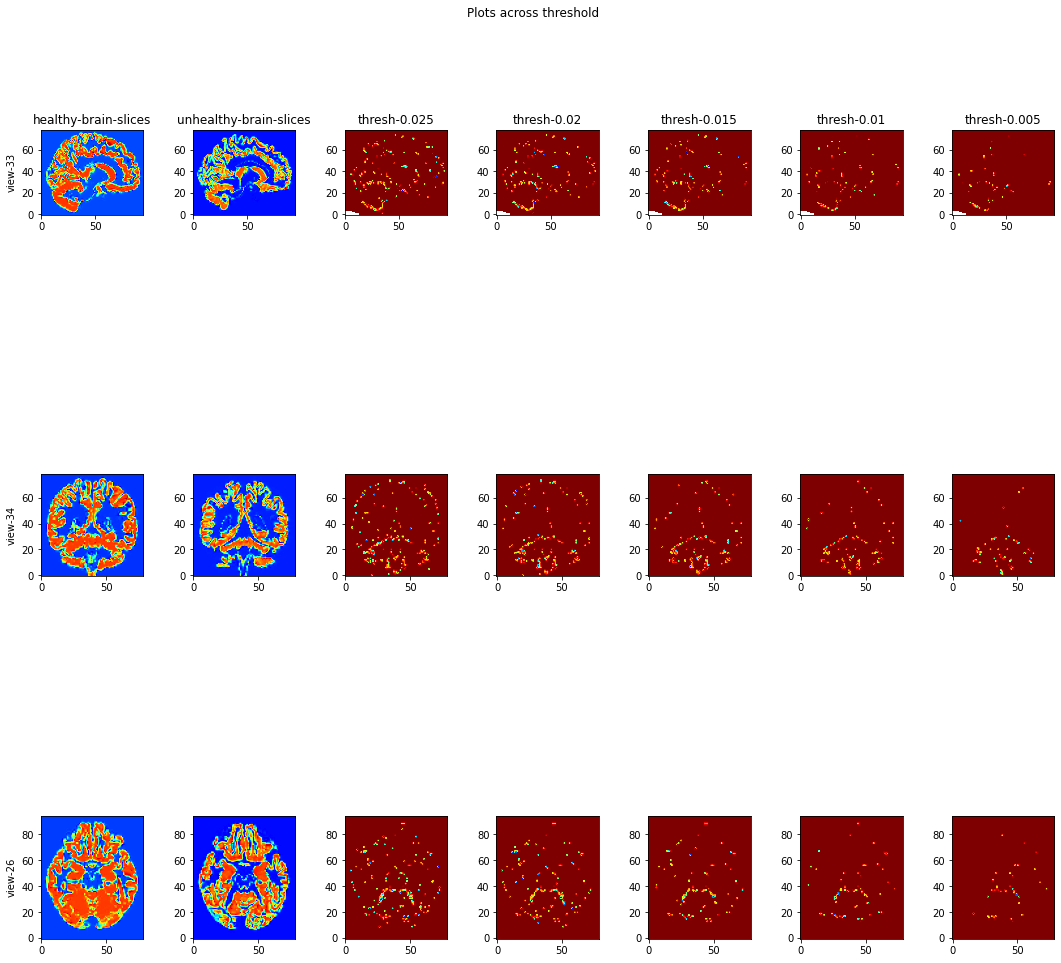

In [204]:
display_deg = []
display_deg.append(x[33,:,:,0])
display_deg.append(x[:,34,:,0])
display_deg.append(x[:,:,26,0])

display_deg.append(y[33,:,:,0])
display_deg.append(y[:,34,:,0])
display_deg.append(y[:,:,26,0])
for thresh in [0.025, 0.02, 0.015, 0.01, 0.005]:
  p = scipy.stats.t.sf(abs(t), df=7)
  i = np.argwhere(p>thresh)
  ind = np.argwhere(t<0)
  for e in ind:
    p[e[0],e[1],e[2]] = 0
  for ind in i:
    p[ind[0],ind[1],ind[2]] = 0
  p = 1-p
  display_deg.append(p[33,:,:])
  display_deg.append(p[:,34,:])
  display_deg.append(p[:,:,26])
row = ['view-33','view-34','view-26']
col = ['healthy-brain-slices','unhealthy-brain-slices','thresh-0.025', 'thresh-0.02', 'thresh-0.015', 'thresh-0.01', 'thresh-0.005']
show_diff(display_deg,row,col,'jet')

Commentary on the plots above: Firstly we will only consider the right tailed case because in regards to brain degenracy it makes more sense to only consider the right tailed test–––you only want to see the areas in the control brains that are depleting in the patients' brains.<br>
As we lower the threshold $\alpha$ we lower the number of false positives whereas when we increease it we increase the number of false positives, as shownn by the 2 figures above. But since we do not know which voxels (ground truth) are/are not part of the actual regions of differences, we cannot compute false positive rates to determine optimal threshold. Instead we explore visually and try to find the threshold which gives high information to noise ratio. If we only focus on the 2nd figure(0/1 voxel image) and the 3rd, clearly $\alpha=0.015$ seems to be the optimal threshold as it contains suffcient amount of differences and low noise.

Individual inspection

control-0 brain slices

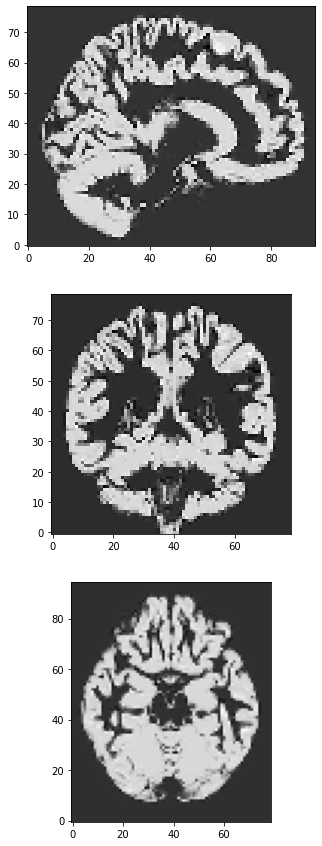

In [205]:
show_slices([x[33,:,:,0],x[:,34,:,0],x[:,:,26,0]])

patient-0 brain slices 

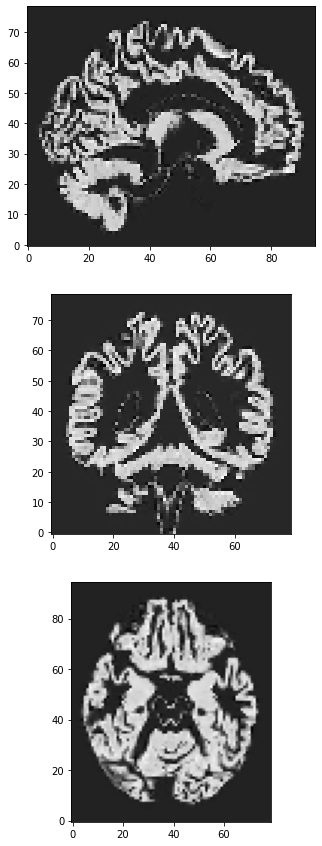

In [206]:
show_slices([y[33,:,:,0],y[:,34,:,0],y[:,:,26,0]])

2 tailed test 0/1 voxel intensity, $\alpha=0.015$

In [214]:
#2 tailed test, alpha = 0.03 , with 0 and 1 valued voxel
p = scipy.stats.t.sf(abs(t), df=7)
p = p<=0.015
p = p.astype(int)

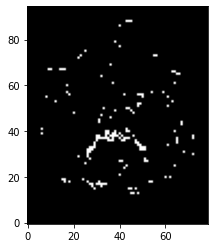

In [215]:
plt.imshow(p[:,:,26].T, cmap="gray", origin="lower")

right tailed test 0/1 voxel intensity, $\alpha=0.015$

In [221]:
#right tailed test, alpha = 0.015, with 0 and 1 valued voxel
p = scipy.stats.t.sf(abs(t), df=7)
p = p<=0.015
ind = np.argwhere(t<0)
for e in ind:
  p[e[0],e[1],e[2]] = 0
p = p.astype(int)

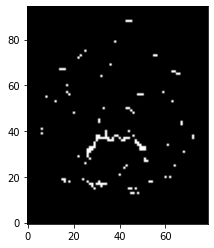

In [222]:
plt.imshow(p[:,:,26].T, cmap="gray", origin="lower")

right tailed test 1-p-valued voxel intensity, $\alpha=0.015$

In [231]:
#right tailed test, alpha = 0.015, with 1-p-valued voxel intensity
p = scipy.stats.t.sf(abs(t), df=7)
i = np.argwhere(p>0.015)
ind = np.argwhere(t<0)
for e in ind:
  p[e[0],e[1],e[2]] = 0
for ind in i:
  p[ind[0],ind[1],ind[2]] = 0
p = 1-p

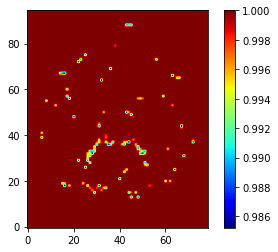

In [232]:
plt.imshow(p[:,:,26].T, cmap="jet", origin="lower")
plt.colorbar()

Save image

In [233]:
new_image = nib.Nifti1Image(p, affine=np.eye(4))

In [234]:
new_image.shape

(79, 95, 79)

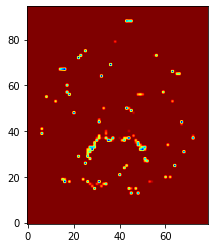

In [235]:
# plt.imshow(new_image.get_fdata()[:,:,26].T, cmap="gray", origin="lower")
plt.imshow(new_image.get_fdata()[:,:,26].T, cmap="jet", origin="lower")

In [236]:
nib.save(new_image,"right_tail-1-p.nii.gz")

LOAD 0/1 single tailed test and plot

In [241]:
img = nib.load('right_tail-01.nii.gz')
img.shape

(79, 95, 79)

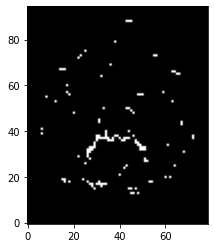

In [242]:
plt.imshow(img.get_fdata()[:,:,26].T, cmap="gray", origin="lower")

LOAD 1-p single tailed test and plot

In [243]:
img = nib.load('right_tail-1-p.nii.gz')
img.shape

(79, 95, 79)

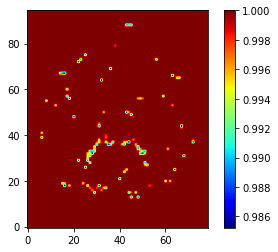

In [244]:
plt.imshow(img.get_fdata()[:,:,26].T, cmap="jet", origin="lower")
plt.colorbar()